# Third Assignment

Carlos
Daniel
Jakob Schwerter (110583)

Things that have to be done:
    - Getting the standard errors in all simulations of the estimation (not the estimator!)
    - Nice plots for all the results to picture the results. 
    - Make plots flexible to paramter changes (for us n, t and beta)
    - If possible, make the code faster / easier
    - Count the time the stata and comparable python code needs
    - Comment on which program to prefer
    - Check typos
    - Loading a dataset to check the simulation results for a empirical dataset

In [29]:
import ipystata # https://github.com/TiesdeKok/ipystata - We kind of helped so that ipystata works on mac as well :)
import numpy as np
import pandas as pd

# pip install ipystata --upgrade --force-reinstall
# Check if a new version is online before running the code.
# Might be useful and does not take much time

# Motivation of the Assignment

The idea of the assignment is to construct a simulation for the random-trend model (Wooldrige 2010, section 11.7.1). 
The random-trend (or growth) is an extension of the fixed-effects model and thereby a panel-data method.
The main interest is to find an unbiased estimator for variables which are biased trough a random-trend. Besides the unobserved constant ($\alpha_i$) the variable of interest ($x_it$) is correlated with a linear trend ($g_i \cdot t$). For this random-trend model, the literatur just states that in the first step we have to calculate the first-difference to transform the linear trend into a constant. Thereafter we it is open to the researcher to continue with the within-tranformation or the first-difference (even though both are a fixed-effect method, we will be consistent with the literatur to call the within-transformation the fixed-effect method). We will investigate if one of the approaches is superior to the other in means of the (bias of the) coefficient [???, standard errors and model selection criteria ($R^2$, AIC and BIC)???].

We thereby have two possibles to calculate the random-trend model: 
- Taking two time the first-difference.
- First the first-difference, then the fixed-effect.

The true DGP is as follows:

$y_{it} = \beta \cdot x_{it} + \alpha_i + g_i \cdot t + e_{it} $

$y_{it}$ is our dependent variable we wish to explain. $x_{it}$ is our variable of interest which we want to estimate, thereby $\beta$ is our parameter of interest. $\alpha_i$ is the constant (un)observable, $g_i \cdot t$ the linear trend (un)observable. $e_{it}$ the idiosyncratic error term which can vary randomly over the individual and periods.

Taking the first-difference gives

$y_{it} - y_{it-1} = \beta \cdot ( x_{it} - x_{it-1}) + \alpha_i - \alpha_{i} +   g_i \cdot t - g_{i} \cdot (t-1) + (e_{it} - e_{it-1})$

$ \iff \Delta y_{it} = \beta \cdot \Delta x_{it} + g_i + \Delta  e_{it}$

One can see that the linear trend is reduced to a constant term which can be canceld out by a second fixed-effects transformation.

Fixed-Effects (i.e. subtracting each varibale by the mean respective to the individual):

$\Delta y'_{it} = \beta \cdot \Delta x'_{it} + \Delta e'_{it}$, whereby ' denotes that the variables are demeanded.

First-Difference:

$\Delta^2 y_{it} = \beta \cdot \Delta^2 x_{it} + \Delta^2 e_{it}$


Taking first the fixed-effects would give the following:

$y_{it} - \bar{y}_{i} = \beta \cdot ( x_{it} - \bar{x}_{i}) + \alpha_i - \alpha_{i} +   g_i \cdot (t - \bar{t}) + (e_{it} - \bar{e}_{i})$

Using a second transformation we will not be able to cancel out the time trend effect (we will confirm this in one simulation at some point).

Given that our group is new to python but experienced in stata, we will actually first do the simulation using stata. We run stata codes using the package `ipystata`. Thereby we have a known language which we can refer to our benchmark. In a second step we will use only open software packages to replicate the results. Thereby we will comment which python code is comparable to which stata code. Despide having the stata-results as a benchmark, we start a nice _translater_ from stata to python for those who are new to python but know stata. We will also command on the speed of both languages as well as advantages and disadvanteges of the coding part.

The assignment will continue as follows: (i) First we will explain step by step our data generating process (DGP). (ii) Then we ran a simulation without a random trend to see if everything works fine. (ii) Next we run the same simulation using a constant linear trend and (iii) a individual specific trend in the data generating process. To see how robust the random-trend estimates are, we will further run two simulations using two non-linear trends.
After that we will reproduce the results of the individual trend using open-source packages only.


# Stata

## Explanation of the Data Generating Process (DGP)
We will first explain the main part of the simulation process. Minor changes or additions however will be denoted later in the code. In _Stata_ commenting within the code is done using " // "

The first two cells are to call the prgroam Stata itself and to see if it actually works.

In [30]:
from ipystata.config import config_stata
config_stata('/Applications/Stata/StataSE.app/Contents/MacOS/StataSE') 

# Windows  --> 'C:\Program Files (x86)\Stata14\StataSE-64.exe'
# Mac OS X --> '/Applications/Stata/StataSE.app/Contents/MacOS/stataSE'
# Linux    --> '/home/user/stata14/stata-se'

In [31]:
%%stata 
display "Hello, I am printed by Stata" 
display "We welcome you to our assignment and we hope you enjoy it"


Hello, I am printed by Stata
We welcome you to our assignment and we hope you enjoy it


In [32]:
%%stata 
cd "/Users/jakobschwerter/Dropbox/github/python/Stata/Assignment" 
set seed 100


/Users/jakobschwerter/Dropbox/github/python/Stata/Assignment


> First we have to _call_ stata using `%%stata`. Then we tell stata where it should (i) look for files and (ii) saves files with the command `cd`.

> We further set the seed to 100, so that results are easier to be reproduced.

In [33]:
%%stata -o simulation
drawnorm alpha_i, n(200)



(obs 200)


>First we create a new dataset called _simulation_ using `-o`. This is necessary for `ipystata` on mac.

>Then we draw 200 iid random numbers of a standard normal distribution with mean zero and variance 1. The give that variable the name $alpha_i$ ($\alpha_i$).

In [34]:
%%stata -d simulation -o simulation
expand 5


(800 observations created)


> `-d` calls the dataset _simulation_ , otherwise the commands afterwards would not find any variables. The command `-o simulation` saves the changes.

> We expand the generated data by 5, i.e. obtainig every alpha 4 additional times
The vector thereby expands from $(200 \; \text{x} \; 1)$ to $(200 \cdot 5 \; \text{x} \; 1)$. Thereby we have a variable which is constant over time.

In [35]:
%%stata -d simulation -o simulation
drawnorm nu_it e_it, n(1000)

> Draw two new variables (or vectors) with now $1000 (5 \cdot 200)$ entries. Two names mean two different variables from a multivariate normal distribution.
Stata first generates one variable with 1000 draws and then the second.
 1000 draws so that it fit with the number of alpha's which where expanded by 5. Both variables are independent from each other, so they are not correlated. The data is iid as well.
 
> To check if we did everything correct, we have a look into summary statistics

In [36]:
%%stata -d simulation
sum 


    Variable |       Obs        Mean    Std. Dev.       Min        Max
-------------+--------------------------------------------------------
       index |      1000       499.5    288.8194          0        999
     alpha_i |      1000   -.0376166    1.014596  -2.885089    2.10282
       nu_it |      1000    .0101147    1.027895  -2.885089   3.081883
        e_it |      1000   -.0310172    .9936022  -2.741925   3.359478


>We see the three generated variables $\alpha_i, \; nu_{it}, \; e_{it}$, having a mean very close to zero and a standard deviation close to 1. Further, using stata in python, and index variable is generated automatically. The index variable would be the individual variable if we would run a pooled panel regression. 

In [37]:
%%stata -d simulation -o simulation
g x_it = nu_it + alpha_i

>Generats our variable of interest $x_{it}$ using two existing variables. Since $\alpha_i$ is a compenent, $x_{it}$ will be correlated over time.

In [38]:
%%stata -d simulation -o simulation
g y_it=3+alpha_i+2*x_it+e_it // DGP

>Generats our dependent variable $y_{it}$. We use
 an intercept, $\alpha_i$, $x_{it}$ and $e_{it}$ for that. 2 is the assigned parameter to $x_{it}$.
 
>The underlying model is a panel data model, consisting of 200 individuals and 5 time periods per person. It is completely balanced. The variables $y_{it}$ and $x_{it}$ are correlated with a constant term $\alpha_i$. This produces autocorrelation within an individual.



>Checking if the code worked:

In [39]:
%%stata -d simulation
pwcorr,sig
corrtex alpha_i e_it x_it y_it, sig 


             |    index  alpha_i    nu_it     e_it     x_it     y_it
-------------+------------------------------------------------------
       index |   1.0000 
             |
             |
     alpha_i |   0.0079   1.0000 
             |   0.8022
             |
       nu_it |   0.0283   0.2159   1.0000 
             |   0.3711   0.0000
             |
        e_it |  -0.0082  -0.0082  -0.0185   1.0000 
             |   0.7967   0.7949   0.5600
             |
        x_it |   0.0233   0.7764   0.7830  -0.0172   1.0000 
             |   0.4612   0.0000   0.0000   0.5880
             |
        y_it |   0.0180   0.8425   0.6525   0.2253   0.9579   1.0000 
             |   0.5701   0.0000   0.0000   0.0000   0.0000
             |
An output file must be specified


> The command _pwcorr_ shows a correlation table of the variables in the dataset (which were generated previously). The option _sig_ prints significance level for each correlation. Results are presented above. $x_it$ and $\alpha_i$ are statistical significant correlated (77.64\%). Not including or solving for $\alpha_i$ when regressing $x_{it}$ on $y_{it}$ will induce a bias. The correlation of $x_{it}$ on $y_{it}$ and $\alpha_i$ is natural very high, since it depends on both variables.
 The correlation of $e_{it}$ with $x_{it}$ and $\alpha_i$ is very low and statistical insignificant, which is necessary and by construction. An OLS model like $y_{it} = \beta x_{it}$  will be upward biased since the correlation of $\alpha_i$ and $x_{it}$ is positive. $\beta$ will estimate the effect of $\alpha$ and $x_{it}$. If the correlation would be negative, it would have been downward biased.

> To check if the DGP is correct, we do one simulation without imposing a trend into the DGP.

# Simulation without Random Trend in the true DGP

In [47]:
%%stata -o sim
timer on 1
qui set seed 100
qui drawnorm alpha_i, n(200)
qui gen i = _n // included additional to generate an index for the individual level
qui expand 5
qui bys i: g t = _n // included additional to generate an index for the time level
qui drawnorm nu_it e_it, n(1000)
qui g x_it = nu_it + alpha_i
qui g y_it = 3 + alpha_i + 2*x_it + e_it // DGP

qui xtset i t //give stata panel-information

qui gen dx_it = d.x_it // generates the first-difference prior to the regression command
qui gen dy_it = d.y_it // generates the first-difference prior to the regression command


qui eststo: reg y_it x_it, cluster(i) // OLS-regression (biased)
qui eststo: xtreg  y_it x_it, fe cluster(i)    // FE-regression
qui eststo: reg d.y_it d.x_it, cluster(i) // FD-regression
qui eststo: xtreg d.y_it d.x_it,fe cluster(i) // Random-Trend
qui eststo: reg d2.y_it d2.x_it, cluster(i) // Random-Trend  (2 FD)
qui eststo: reg d.dy_it d.dx_it, cluster(i) // Random-Trend  (FD-FD)    

esttab, long compress nogaps rename(D.x_it x_it D2.x_it x_it D.dx_it x_it Constant C) ///
	b(%7,5f) se(%6.3f) scalars("N N" "r2_a r2_a)" "F F-Stat" "p p-value" "r2 r2" "aic aic" "bic") sfmt(%4,0f %6,5f %5,2f %5,4f %6,5f %9,2f %9,2f) star(+ 0.1 * 0.05 ** 0.01 *** 0.001) ///
	label mtitles( "OLS" "FE" "FD" "FD-FE" "2-FD" "FD-FD" ) title("Without a random trend component") nolabel replace 
timer off 1
display "Time needed to run:"
timer list 1


>         b(%7,5f) se(%6.3f) scalars("N N" "r2_a r2_a)" "F F-Stat" "p p-value" "r2 r2" "aic aic" "bic") sfmt(%4,0f %6,5f %5,2f %5,4f %6,5f %9,2f %9,2f) star(+ 0.1 * 0.05 ** 0.01 *** 0.001) ///
>         label mtitles( "OLS" "FE" "FD" "FD-FE" "2-FD" "FD-FD" ) title("Without a random trend component") nolabel replace 

Without a random trend component
----------------------------------------------------------------------------------------------
                       (1)          (2)          (3)          (4)          (5)          (6)   
                       OLS           FE           FD        FD-FE         2-FD        FD-FD   
----------------------------------------------------------------------------------------------
x_it               2,47702***   2,02807***   2,03600***   2,03628***   2,02678***   2,02678***
                   (0.033)      (0.036)      (0.044)      (0.046)      (0.056)      (0.056)   
Constant           2,96331***   3,01220***   0,02163      0,02164***   0,0500

> We can see that the results of the normal OLS are biased, i.e. the coefficient for $x_{it}$ is not 2 but around 2.4. For the within-transformation and the first-difference however the coefficient if very close to 2.
Also the random-trend is unbiased, but it seems that the second transformation worsens the results. It is farthermost of 2 and also the standard error is the highest. Also the F-Stat, adjusted $R^2$, $R^2$ and AIC decreased (Just for the AIC and BIC, the FE is the worst). So we can conclude that even if we do not have a random-trend component, using two transformations does not really harm the estimation.

> Comparing the different Random Trend calculations, we see (i) the the mixture seem to be more efficient, but the pure is closer to the true value (2) and (ii) that (5) and (6) are excatly the same. 

# Monte Carlo Study without Trend

In a simulation however, results from just one run can be misleading, because the results can be driven by chance, i.e. if the seed in use just draws numbers which workes better for one method than the other. Therefore, we will run a programm now to do a monte carlo study. We will take 1000 draws to see if above resusts are robust.

New in the code is (i) a timer which measure the time the code runs. The necessary commands are `timer on 1`, starting the timer, called '1', `timer off 1`, stopping the started timer and `timer list 1`, displaying the time needed.
(ii) For the simulation commands `simulation`, we first have to embed the code in a program. The first line `capture program drop mcprog_ols` drops if somehow the program is already defined. This command is useful if you run the code an additional time. `program mcprog_ols` starts the program and ends with `end`.

Then the simulation just simulate the coefficients saved in stata in `_b` (given the time, we focus on the coefficients and leave out the standard errors). We take 1000 replications and we call the earlier defined programm `mcprog_pool` (Monte Carlo Program - Pooled Regression). 

At the end we rename the coefficient for a better understanding and drop everything else from the dataframe (`keep beta_pool`).

Using `-np` only suppresses any output. We will compare the combined output later on.

_pool_ stands for the pooled regress, _fe_ for the within-transformation, _fd_ for the first-difference, _mix_ for the random-trend, using first-difference and fixed-effects and _pure_ the random trend with two first-differences.

In [13]:
%%stata -o pool 
timer on 1
set seed 100
capture program drop mcprog_pool
program mcprog_pool
         clear
         drawnorm alpha_i, n(200)
         gen i = _n // included additional to generate an index for the individual level
         expand 5
         bys i: g t = _n // included additional to generate an index for the time level
         drawnorm nu_it e_it, n(1000)
         g x_it=nu_it+alpha_i
         g y_it=3+alpha_i+2*x_it+e_it
         reg y_it x_it, // cluster(i) Take out the clustered standard errors because we focus on the coefficients
         drop nu_it alpha_i e_it y_it x_it
end
        simulate _b, nodots nolegend  reps(1000): mcprog_pool
        rename _b_x_it beta_pool
        keep beta_pool
timer off 1
display "The time this codes run is"
timer list 1



The time this codes run is
   1:     14.27 /        1 =      14.2700


In [9]:
%%stata -o fe
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
         clear
         drawnorm alpha_i, n(200)
         gen i = _n // included additional to generate an index for the individual level
         expand 5
         bys i: g t = _n // included additional to generate an index for the time level
         drawnorm nu_it e_it, n(1000)
         g x_it=nu_it+alpha_i
         g y_it=3+alpha_i+2*x_it+e_it
         xtset i t
         xtreg y_it x_it, fe // cluster(i)
         drop nu_it alpha_i e_it y_it x_it
end
        simulate _b, nodots nolegend  reps(1000): mcprog_fe
        rename _b_x_it beta_fe
        keep beta_fe
timer off 1
display "The time this codes run is"
timer list 1
        

In [10]:
%%stata -o fd
timer on 1
set seed 100
capture program drop mcprog_fd
        program mcprog_fd
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        drawnorm nu_it e_it, n(1000)
        g x_it=nu_it+alpha_i
        g y_it=3+alpha_i+2*x_it+e_it
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        reg dy_it dx_it, // cluster(i)
        drop nu_it alpha_i e_it dy_it dx_it y_it x_it
end
        simulate _b, nodots nolegend  reps(1000): mcprog_fd
        rename _b_dx_it beta_fd
        keep beta_fd
timer off 1
display "The time this codes run is"
timer list 1
        
        

In [11]:
%%stata -o mix
timer on 1
set seed 100
capture program drop mcprog_mix
        program mcprog_mix
         clear
         drawnorm alpha_i, n(200)
         gen i = _n // included additional to generate an index for the individual level
         expand 5
         bys i: g t = _n // included additional to generate an index for the time level
         drawnorm nu_it e_it, n(1000)
         g x_it=nu_it+alpha_i
        g y_it=3+alpha_i+2*x_it+e_it
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
         xtreg dy_it dx_it, fe // cluster(i)
         drop nu_it alpha_i e_it dy_it dx_it y_it x_it
end
        simulate _b, nodots nolegend  reps(1000): mcprog_mix
        rename _b_dx_it beta_mix
        keep beta_mix
        
timer off 1
display "The time this codes run is"
timer list 1

In [12]:
%%stata -o pure
timer on 1
set seed 100
capture program drop mcprog_pure
        program mcprog_pure
         clear
         drawnorm alpha_i, n(200)
         gen i = _n // included additional to generate an index for the individual level
         expand 5
         bys i: g t = _n // included additional to generate an index for the time level
         drawnorm nu_it e_it, n(1000)
         g x_it=nu_it+alpha_i
         g y_it=3+alpha_i+2*x_it+e_it
        xtset i t
        g d2x_it = d2.x_it
        g d2y_it = d2.y_it
         reg d2y_it d2x_it, // cluster(i)
         drop nu_it alpha_i e_it y_it x_it d2y_it d2x_it
end
        simulate _b, nodots nolegend  reps(1000): mcprog_pure
        rename _b_d2x_it beta_pure
        keep beta_pure
        
timer off 1
display "The time this codes run is"
timer list 1

In [15]:
pool_mean = pool.mean()
fe_mean = fe.mean()
fd_mean = fd.mean()
mix_mean = mix.mean()
pure_mean = pure.mean()

mean = [pool_mean, fe_mean, fd_mean, mix_mean, pure_mean]
mean
meanv = np.array([pool_mean, fe_mean, fd_mean, mix_mean, pure_mean])
meanv



array([[ 2.49910474],
       [ 2.001513  ],
       [ 2.00073147],
       [ 2.00057745],
       [ 1.99920857]], dtype=float32)

> We can see that the pooled regression is upward biased form the true value (2). Closest to the true are (??? -should calulate the difference to the true here???)
Further, we could include histograms, but I could not do it easily.


# Monte Carlo Study with the same trend for all individuals

Here we investigate what happens to our estimator is we include the same trend for all individual. If we would just run normal regression as presented first, we could just use the same datasets, replacing just some variables. But since we have to define programs, we need to copy all the programs and change for the trend. We will leave out the pooled regression because we already know, that this one is biased just due to the constant $\alpha_i$.

In [16]:
%%stata -o fe_st
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + t // NOW: x_it is correlated with a linear term
        g y_it = 3 + alpha_i + 2*x_it + t + e_it // DGP includes know the linear trend
        xtset i t
        xtreg y_it x_it, fe // cluster(i)
        drop nu_it alpha_i e_it y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_x_it beta_fe_st
        keep beta_fe_st // st = same trend
timer off 1
display "The time this codes run is"
timer list 1


The time this codes run is
   1:      6.90 /        1 =       6.9040


In [22]:
%%stata -o fd_st
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + t // NOW: x_it is correlated with a linear term
        g y_it = 3 + alpha_i + 2*x_it + t + e_it // DGP includes know the linear trend
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        reg dy_it dx_it, // cluster(i)
        drop nu_it alpha_i e_it y_it x_it dy_it dx_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_dx_it beta_fd_st
        keep beta_fd_st
timer off 1
display "The time this codes run is"
timer list 1


The time this codes run is
   1:      1.98 /        1 =       1.9790


In [24]:
%%stata -o mix_st
timer on 1
set seed 100
capture program drop mcprog_mix
        program mcprog_mix
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + t // NOW: x_it is correlated with a linear term
        g y_it = 3 + alpha_i + 2*x_it + t + e_it // DGP includes know the linear trend
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        xtreg dy_it dx_it, fe // cluster(i)
        drop nu_it alpha_i e_it dy_it dx_it y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_mix
        rename _b_dx_it beta_mix_st
        keep beta_mix_st
        
timer off 1
display "The time this codes run is"
timer list 1


. timer off 1
The time this codes run is
   1:      6.30 /        1 =       6.3000


In [26]:
%%stata -o pure_st
timer on 1
set seed 100
capture program drop mcprog_pure
        program mcprog_pure
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + t // NOW: x_it is correlated with a linear term
        g y_it = 3 + alpha_i + 2*x_it + t + e_it // DGP includes know the linear trend
        xtset i t
        g d2x_it = d2.x_it
        g d2y_it = d2.y_it
        reg d2y_it d2x_it, // cluster(i)
        drop nu_it alpha_i e_it y_it x_it d2y_it d2x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_pure
        rename _b_d2x_it beta_pure_st
        keep beta_pure_st
        
timer off 1
display "The time this codes run is"
timer list 1


. timer off 1
The time this codes run is
   1:      1.97 /        1 =       1.9690


In [27]:
fe_st_mean = fe_st.mean()
fd_st_mean = fd_st.mean()
mix_st_mean = mix_st.mean()
pure_st_mean = pure_st.mean()


meanv = np.array([fe_st_mean, fd_st_mean, mix_st_mean, pure_st_mean])
meanv

array([[ 2.71409535],
       [ 2.00397825],
       [ 2.00418329],
       [ 2.00259447]], dtype=float32)


>The simulation shows that if the trend is the same for all individuals in the data, the within-transformation cannot capture the linear trend. Thereby the coefficent is biased. Suprisingly the first-difference is enough to solve for the problem introduced by a correlation of the variable of interest and the trend. We will not take a deeper look here, but it might be interest to investigate how many individuals are allowed to differ so that the first-difference is not unbiased anymore (or should we?)
It seems that the First-Difference is more robust here. It is however questionable in practice if the observed individuals really follow the same trend.

>Further, the first-difference performs better than the mixe, but worse than the pure.

# Monte Carlo study with individual specific trends (Random Trend)



In [32]:
%%stata -o fe_it
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n 
        expand 5
        bys i: g t = _n 
        gen trend = t*i // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        xtreg y_it x_it, fe // cluster(i)
        drop nu_it alpha_i e_it y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_x_it beta_fe_it
        keep beta_fe_it // it = individual trend
timer off 1
display "The time this codes run is"
timer list 1


The time this codes run is
   1:      5.39 /        1 =       5.3900


In [29]:
%%stata -o fd_it
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        gen trend = t*i // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        reg dy_it dx_it, // cluster(i)
        drop nu_it alpha_i e_it y_it x_it dy_it dx_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_dx_it beta_fd_it
        keep beta_fd_it
timer off 1
display "The time this codes run is"
timer list 1


The time this codes run is
   1:      2.31 /        1 =       2.3130


In [30]:
%%stata -o mix_it
timer on 1
set seed 100
capture program drop mcprog_mix
        program mcprog_mix
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        gen trend = t*i // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        xtreg dy_it dx_it, fe // cluster(i)
        drop nu_it alpha_i e_it dy_it dx_it y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_mix
        rename _b_dx_it beta_mix_it
        keep beta_mix_it
        
timer off 1
display "The time this codes run is"
timer list 1


. timer off 1
The time this codes run is
   1:      6.58 /        1 =       6.5770


In [31]:
%%stata -o pure_it
timer on 1
set seed 100
capture program drop mcprog_pure
        program mcprog_pure
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        gen trend = t*i // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g d2x_it = d2.x_it
        g d2y_it = d2.y_it
        reg d2y_it d2x_it, // cluster(i)
        drop nu_it alpha_i e_it y_it x_it d2y_it d2x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_pure
        rename _b_d2x_it beta_pure_it
        keep beta_pure_it
        
timer off 1
display "The time this codes run is"
timer list 1


. timer off 1
The time this codes run is
   1:      2.15 /        1 =       2.1460


In [33]:
fe_it_mean = fe_it.mean()
fd_it_mean = fd_it.mean()
mix_it_mean = mix_it.mean()
pure_it_mean = pure_it.mean()


meanv = np.array([fe_it_mean, fd_it_mean, mix_it_mean, pure_it_mean])
meanv

array([[ 2.99995708],
       [ 2.9994812 ],
       [ 2.00418329],
       [ 2.00259447]], dtype=float32)

>The results confirm (unsurprisingly) the bad results of the within-tranformation. Now, also the first-difference is not capable to control for the trend within $x_{it}$. Only unbiased estimations are _mix_ and _pure_. The results are the same as before (remember: same seed). After checking that twe really changed the code, it can be concluded that for the random-trend model it does not matter whether the trend is constant or individual specific.

> In this easy example it further seems that the double difference (_pure_) is more robust, i.e. closer to the true value. Thereby the example is in favor to use the _pure_ rather than the _mix_ random-trend method. Also the time point, the _pure_ is much faster.

# Monte Carlo study with nonlinear individual specific trends (Random Trend)

We will check for two cases, an exponential individual specific trend and a log individual specific trend. The motivation is if one of the random-trend methods performs better even if the baseline assumption, that the trend is linear, does not hold.

### Monte Carlo study with exponential individual specific trends (Random Trend)


In [44]:
%%stata -o fd_exp
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        gen trend = exp(t*i) // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        reg dy_it dx_it, // cluster(i)
        drop nu_it alpha_i e_it y_it x_it dy_it dx_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_dx_it beta_fd_exp
        keep beta_fd_exp
timer off 1
display "The time this codes run is"
timer list 1


The time this codes run is
   1:      2.33 /        1 =       2.3270


In [41]:
%%stata -o mix_exp
timer on 1
set seed 100
capture program drop mcprog_mix
        program mcprog_mix
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        gen trend = exp(t*i) // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        xtreg dy_it dx_it, fe // cluster(i)
        drop nu_it alpha_i e_it dy_it dx_it y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_mix
        rename _b_dx_it beta_mix_exp
        keep beta_mix_exp
        
timer off 1
display "The time this codes run is"
timer list 1


. timer off 1
The time this codes run is
   1:      6.16 /        1 =       6.1560


In [42]:
%%stata -o pure_exp
timer on 1
set seed 100
capture program drop mcprog_pure
        program mcprog_pure
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        gen trend = exp(t*i) // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g d2x_it = d2.x_it
        g d2y_it = d2.y_it
        reg d2y_it d2x_it, // cluster(i)
        drop nu_it alpha_i e_it y_it x_it d2y_it d2x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_pure
        rename _b_d2x_it beta_pure_exp
        keep beta_pure_exp
        
timer off 1
display "The time this codes run is"
timer list 1


. timer off 1
The time this codes run is
   1:      2.43 /        1 =       2.4290


In [45]:
fd_exp_mean = fd_exp.mean()
mix_exp_mean = mix_exp.mean()
pure_exp_mean = pure_exp.mean()

meanv = np.array([fd_exp_mean, mix_exp_mean, pure_exp_mean])
meanv

array([[ 3.        ],
       [ 3.00000024],
       [ 3.        ]], dtype=float32)

> Here we have the case that the trend increases individual specific exponential over time, i.e. convex
Both are biased, and the difference between the two is at the 7. digit, so obsolete. Suprisingly to us is, that there is no difference between the normal first-difference. This means that if the trend is not linear, the random trend method does not improve the estimation. I would have expected that the rantom-trend model comes a bite closer to the true, but in this example it does not.

> ### Monte Carlo study with exponential individual specific trends (Random Trend)

In [46]:
%%stata -o fd_log
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n 
        expand 5
        bys i: g t = _n 
        gen trend = log(t*i) // logarithm !!! 
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend 
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        reg dy_it dx_it
        drop nu_it alpha_i e_it y_it x_it dy_it dx_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_dx_it beta_fd_log
        keep beta_fd_log
timer off 1
display "The time this codes run is"
timer list 1


The time this codes run is
   1:      3.98 /        1 =       3.9800


In [47]:
%%stata -o mix_log
timer on 1
set seed 100
capture program drop mcprog_mix
        program mcprog_mix
        clear
        drawnorm alpha_i, n(200)
        gen i = _n 
        expand 5
        bys i: g t = _n 
        gen trend = log(t*i) // logarithm!
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend 
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g dx_it = d.x_it
        g dy_it = d.y_it
        xtreg dy_it dx_it, fe // cluster(i)
        drop nu_it alpha_i e_it dy_it dx_it y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_mix
        rename _b_dx_it beta_mix_log
        keep beta_mix_log
        
timer off 1
display "The time this codes run is"
timer list 1


. timer off 1
The time this codes run is
   1:      7.34 /        1 =       7.3440


In [49]:
%%stata -o pure_log
timer on 1
set seed 100
capture program drop mcprog_pure
        program mcprog_pure
        clear
        drawnorm alpha_i, n(200)
        gen i = _n // included additional to generate an index for the individual level
        expand 5
        bys i: g t = _n // included additional to generate an index for the time level
        gen trend = log(t*i) // individual specific trand   
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend // NOW: x_it is correlated with a linear specific term
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        g d2x_it = d2.x_it
        g d2y_it = d2.y_it
        reg d2y_it d2x_it, // cluster(i)
        drop nu_it alpha_i e_it y_it x_it d2y_it d2x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_pure
        rename _b_d2x_it beta_pure_log
        keep beta_pure_log
        
timer off 1
display "The time this codes run is"
timer list 1
    


. timer off 1
The time this codes run is
   1:      2.27 /        1 =       2.2740


In [51]:
fd_log_mean = fd_log.mean()
mix_log_mean = mix_log.mean()
pure_log_mean = pure_log.mean()

meanv = np.array([fd_log_mean, mix_log_mean, pure_log_mean])
meanv

array([[ 2.02005911],
       [ 2.02132511],
       [ 2.00435495]], dtype=float32)

> Here we have the case that the trend is upward sloping, but the marginal increase decreases, i.e. we have cancove trends.
All three methods are suprisingly good in capturing the _unobserved_ trend component. As for the constant trend, the _mixe_ performs worst, _fd_ second and _pure_ performs best.

### The not-working within-transformation first-step: 
At the very top we stated that it does not make any sense to first transform the data using the within-transformation and then using the first-difference. For the canceling of the trend, it was crucial to take first the first-difference. We will investigate this in the following using the following code:

In [37]:
%%stata -o fe_fe
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n 
        expand 5
        bys i: g t = _n 
        gen trend = t*i  
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend 
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        xtdata i t x_it y_it, fe clear // preforms the within-transformation, so we can be sure that it is really the first thing in the regression
        xtreg y_it x_it, fe //  Random-Trend (FE-FD)
        drop y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_x_it beta_fe_fe
        keep beta_fe_fe // it = individual trend
timer off 1
display "The time this codes run is"
timer list 1




The time this codes run is
   1:     10.57 /        1 =      10.5670


In [39]:
%%stata -o fe_fd
timer on 1
set seed 100
capture program drop mcprog_fe
        program mcprog_fe
        clear
        drawnorm alpha_i, n(200)
        gen i = _n 
        expand 5
        bys i: g t = _n 
        gen trend = t*i  
        drawnorm nu_it e_it, n(1000)
        g x_it = nu_it + alpha_i + trend 
        g y_it = 3 + alpha_i + 2*x_it + trend + e_it 
        xtset i t
        xtdata i t x_it y_it, fe clear // preforms the within-transformation, so we can be sure that it is really the first thing in the regression
        xtset i t // to sort the data
        g dx_it = d.x_it
        g dy_it = d.y_it
        reg dy_it dx_it,  // Random-Trend (FE-FD)
        drop y_it x_it
end
        simulate _b, nodots nolegend  reps(100): mcprog_fe
        rename _b_dx_it beta_fe_fd
        keep beta_fe_fd // it = individual trend
timer off 1
display "The time this codes run is"
timer list 1


The time this codes run is
   1:      3.69 /        1 =       3.6920


In [40]:
fe_fe_mean = fe_fe.mean()
fe_fd_mean = fe_fd.mean()

meanv = np.array([fe_fe_mean, fe_fd_mean])
meanv

array([[ 2.99995708],
       [ 2.9994812 ]], dtype=float32)

> Results are similar to the normal within-tranformation. Doing the second transformation is not helpful at all, i.e. the results confirm the theoretical model.

# The same using Python:

In [4]:
#import scipy as sp
from pandas import *
import pandas
#import rpy2.robjects as ro
import random

#import numpy.random as R
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
#import pylab as P
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
random.seed(100)
n = 200
T = 5
N = n * T
alpha_i = np.random.normal(0, 1, 200) # Equivalent to `drawnorm alpha_i, n(200)`
alpha_i = np.repeat(alpha_i,5) # Equivalent to `expand 5`  

# Equivalent for the 'expand 5' command, so we will have 5 time periods
i = ro.r('seq(1,200,1)')# Using sequence generator from R

i = np.array(i) # Equivalent to `gen i = _n`
i = np.repeat(i,5)

t = np.arange(5) + 1 # Equivalent to bys i: g t = _n 
t = np.tile(t,200)
#t.shape
trend = t*i # <=> `gen trend = t*i`

mean = [0, 0]
cov = [[1, 0], [0, 1]]
nu_it, e_it = np.random.multivariate_normal(mean, cov, 1000).T # <=> `drawnorm nu_it e_it, n(1000)`

x_it = (nu_it + alpha_i + trend).T # <=> `g x_it = nu_it + alpha_i + trend`
# Since we will transform the data at least ones, we don't have to include an intercept in the first place.

y_it = (3 + alpha_i + 2*x_it + trend + e_it).T # <=> `g y_it = 3 + alpha_i + 2*x_it + trend + e_it `



m = np.matrix((i, t, alpha_i, trend, y_it, x_it, e_it))
mt = m.transpose()

df = pd.DataFrame(mt)
df.columns = ["Individual", "Time", "alpha_i", "trend", "y_it", "x_it", "e_it"]
#print(df)

#np.set_printoptions(precision=3, suppress=True)
#print(mt)
#y_it.shape

     Individual  Time   alpha_i  trend         y_it        x_it      e_it
0             1     1 -0.315619      1     5.966723    0.938004  0.406333
1             1     2 -0.315619      2    10.755261    2.813945  0.442990
2             1     3 -0.315619      3     7.405965    1.378846 -1.036109
3             1     4 -0.315619      4    14.477653    4.473510 -1.153749
4             1     5 -0.315619      5    15.647115    3.662680  0.637374
5             2     1 -0.451261      2     7.723998    1.533979  0.107301
6             2     2 -0.451261      4    16.808943    4.416874  1.426456
7             2     3 -0.451261      6    21.083685    6.690712 -0.846477
8             2     4 -0.451261      8    25.771535    7.709322 -0.195847
9             2     5 -0.451261     10    31.494125   10.567407 -2.189428
10            3     1  0.983558      3    10.620450    2.318532 -1.000171
11            3     2  0.983558      6    24.865002    7.089636  0.702173
12            3     3  0.983558      9

The data generating process is here now down completely using open source packages. The arising problem now however is, that our internet research did not provide us bith commands which can analyse panel data as easily as stata can do. I.e. there is no command which is directly comparable to 
`xtset i t` and `xtreg y_it x_it, fe`. We therefor have to construct the transformations ourselfs. We will start with taking the first-difference

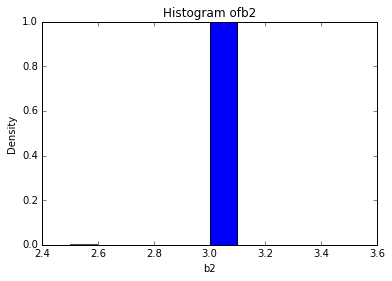

('Parameters: ', array([ 2.99971809]))
('Parameters: ', array([ 2.00802103]))


In [6]:


x_reshape = np.reshape(np.ravel(x_it), (200, 5)).T # reshape x-variable to wide form for the transformation
    # To verify the reshape command, comment out the next to lines. We need 200 columsn with each 5 rows for 200 individuals haven 5 time periods
    #x_df = pd.DataFrame(x_reshape)
    #print x_df.head(n=5) # One can see that we have now 200 columns with each 5 time periods
dx = np.zeros(x_reshape.shape) #Constructing a zero variable for the first-difference command which is following (this is necessary)
dx[1:] = x_reshape[1:] - x_reshape[:-1] # First-Difference
dx = np.delete(dx,(0), axis=0) # Dropping the first period which does not contain any information anymore.
    # Every dirst-difference means that we will lose one time period.
    #dx = numpy.delete(dx,(0), axis=1)
d2x = np.zeros(dx.shape) #Constructing a zero variable for the first-difference command which is following (this is necessary)
d2x[1:] = dx[1:] - dx[:-1] # Second-Difference
d2x = np.delete(d2x,(0), axis=0)
    # For verification command out the next lines:
    #dx_df = pd.DataFrame(dx)
    #print dx_df.head(n=5) # The first entry is now zero for all zero because we can't take the first-difference from the starting value. Comparing dx_df and x_df one can clearly see that the first-differnce worked well.
    # Now we have the reshape the data again in long form for the regression
dx = np.reshape(dx.T, N-n) # replacing dx with long form (to be used in a regression)
# We have to substract n from N, because we delete one time period
d2x = np.reshape(d2x.T, N-2*n)
# Same here, just that now we deleted two time periods.
    #dx[:11] #to check if transition worked

################ Some transition for the y-variable
y_reshape = np.reshape(np.ravel(y_it), (200, 5)).T # reshape x-variable to wide form for the transformation
dy = np.zeros(y_reshape.shape) #Constructing a zero variable for the first-difference command which is following (this is necessary)
dy[1:] = y_reshape[1:] - y_reshape[:-1] # First-Difference
dy = np.delete(dy,(0), axis=0) # Dropping the first period which does not contain any information nomore.

d2y = np.zeros(dy.shape) #Constructing a zero variable for the first-difference command which is following (this is necessary)
d2y[1:] = dy[1:] - dy[:-1] # Second-Difference
d2y = np.delete(d2y,(0), axis=0)

dy = np.reshape(dy.T, N-n)
d2y = np.reshape(d2y.T, N-2*n)

x = np.mat(dx).T
y = np.mat(dy).T
estimate = (x.T * x).I * x.T * y



model = sm.OLS(dy, dx)
results = model.fit()
#print(results.summary())
print('Parameters: ', results.params)



model = sm.OLS(d2y, d2x)
results = model.fit()
#print(results.summary())
print('Parameters: ', results.params)

[[ 3.]]
(800, 1)
(800, 1)


We can clearly see that the first regression, where we just use one difference, is biased as it was in the stata code. For the second estimation, we get and unbiased estimator. It seems that the transformation using python (or numpy) worked. This however was just for one simulation. As we did before, we should now repeat the simulation several times.


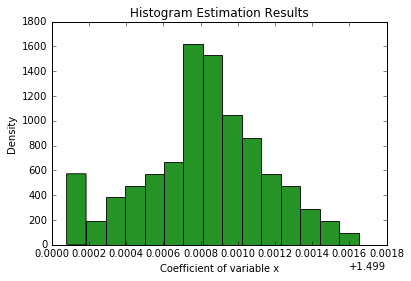

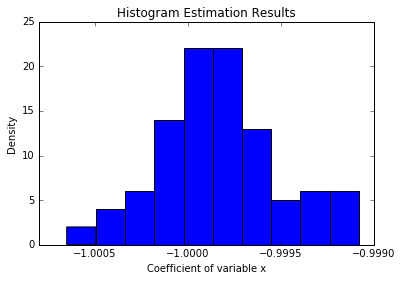

In [22]:
r = 100 # number of replications
n = 200
T = 5
N = n * T
intercept = 3
beta = 0.5
estimate = np.mat(np.empty((1, r)))
for j in range(0, r):
    # DGP
    random.seed(r)
    alpha_i = np.random.normal(0, 1, n)
    alpha_i = np.repeat(alpha_i,T) 
    i = np.arange(n)
    i = np.repeat(i,T)
    t = np.arange(T) + 1 
    t = np.tile(t,n)
    trend = t*i 
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    nu_it, e_it = np.random.multivariate_normal(mean, cov, N).T 
    x_it = (nu_it + alpha_i + trend).T 
    y_it = (intercept + alpha_i + beta*x_it + trend + e_it).T # <=> `g y_it = 3 + alpha_i + 2*x_it + trend + e_it `
    ########## Transformation
    x_reshape = np.reshape(np.ravel(x_it), (n, T)).T 
    dx = np.zeros(x_reshape.shape)
    dx[1:] = x_reshape[1:] - x_reshape[:-1] 
    dx = np.delete(dx,(0), axis=0) 
    d2x = np.zeros(dx.shape) 
    d2x[1:] = dx[1:] - dx[:-1] 
    d2x = np.delete(d2x,(0), axis=0)
    dx = np.reshape(dx.T, N-n) 
    d2x = np.reshape(d2x.T, N-2*n)

    y_reshape = np.reshape(np.ravel(y_it), (n, T)).T 
    dy = np.zeros(y_reshape.shape)
    dy[1:] = y_reshape[1:] - y_reshape[:-1] 
    dy = np.delete(dy,(0), axis=0) 
    d2y = np.zeros(dy.shape)
    d2y[1:] = dy[1:] - dy[:-1] 
    d2y = np.delete(d2y,(0), axis=0)
    dy = np.reshape(dy.T, N-n)
    d2y = np.reshape(d2y.T, N-2*n)
    x = np.mat(dx).T
    y = np.mat(dy).T
    M = (x.T * x).I * x.T
    estimate[:, j] = M * y
        
mu = estimate.mean()
var = estimate.var()
sigma = np.sqrt(var)
estimate = np.squeeze(np.asarray(estimate))

#axis = np.round(estimate,4)
#h = plt.hist(np.round(estimate,2))    
n, bins, patches = plt.hist(np.round(estimate,6), 15, normed=1, facecolor='g', alpha=0.85)
#plt.axis([2.9981, 3.0009, 0, 25])
plt.xlabel('Coefficient of variable x'); plt.ylabel('Density'); plt.title('Histogram Estimation Results')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.show()

diff = beta - estimate
h = plt.hist(diff)    
#n, bins, patches = plt.hist(estimate, 12, normed=1, facecolor='g', alpha=0.85)
#plt.axis([2.9981, 3.0009, 0, 25])
plt.xlabel('Coefficient of variable x'); plt.ylabel('Density'); plt.title('Histogram Estimation Results')
#plt.text(20, -1.0005, r'$\mu=100,\ \sigma=15$')
plt.show()


In [160]:
i = ro.r('seq(1,200,1)')
#print i
m = np.arange(200)
#print m
type(m)

numpy.ndarray

In [14]:
type(estimate)
diff = 0.5 - estimate

In [66]:
estimate2 = np.mat(np.zeros((1,10)))
estimate2[:, 1] = 1
estimate2[:, 2] = 2
print estimate2

[[ 0.  1.  2.  0.  0.  0.  0.  0.  0.  0.]]


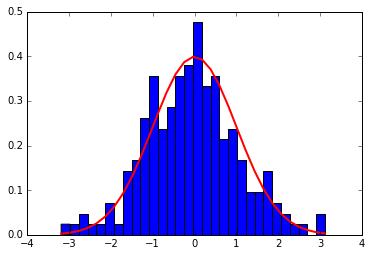

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
mu = 0
sigma = 1
s = np.random.normal(0, 1, 200)
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [104]:
type(s)


numpy.ndarray

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mu, sigma = 100, 15
x = mu + sigma * np.random.randn(1000)

# the histogram of the data
n, bins, patches = plt.hist(estimate, 50, normed=1, facecolor='g', alpha=0.75)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()